# Лабораторная работа 3: Машина опорных векторов (SVM)

<img src="svm_img.png" width=350>

Результат лабораторной работы — **отчет** в формате ноутбуков IPython (ipynb-файл). Нам не интересен ваш код. Чем меньше кода, тем лучше всем: нам — меньше проверять, вам — проще найти ошибку или дополнить эксперимент.

Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Ответы на вопросы должны быть полными, четкими и хорошо аргументированными.

## 1. Квадратичное программирование и QP-солвер

Квадратичное программирование (QP) — специальный тип задач математической оптимизации, заключающийся в нахождении точки минимума неотрицательно-определенной квадратичной формы (многомерная парабола) в присутствии линейных ограничений:
$$
\begin{gather}
    \frac{1}{2}\boldsymbol x^T\boldsymbol P\boldsymbol x + \boldsymbol q^T\boldsymbol x \to \min_{\boldsymbol x} \\
    \begin{aligned}
        \text{s.t.} \quad & \boldsymbol G\boldsymbol x \le \boldsymbol h \\
        & \boldsymbol A\boldsymbol x = \boldsymbol b
    \end{aligned}
\end{gather}
$$

Здесь $\boldsymbol P$ — симметричная матрица. В ограничениях $\boldsymbol G\boldsymbol x \le \boldsymbol h$ и $\boldsymbol A\boldsymbol x = \boldsymbol b$ под знаками равенства и неравенства подразумевается сравнение всех компонент векторов.

Задача квадратичного программирования хорошо изучена, существуют эффективные алгоритмы для ее решения. Имеется множество библиотек с солверами для задачи QP, вот некоторые из них:
 - [CVXOPT](http://cvxopt.org/) (свободно-распространяемая, Python) **рекомендуется к использованию**
 - [Mosek](https://www.mosek.com/) (коммерческая с возможностью получения академической лицензии, C, Java, MATLAB, .NET, R, Python)
 - [Matlab Optimization Toolbox](http://www.mathworks.com/help/optim/ug/quadprog.html) 

#### Задание

1. Установите QP-солвер, разберитесь с его интерфейсом.
2. Протестируйте солвер, решив простую задачу оптимизации в двумерном пространстве:
$$f(\boldsymbol x) = -8x_1 - 16x_2 + x_1^2 + 4x_2^2, \quad \text{s.t.:} \; x_1 + x_2 \leq 5, \; 0 \leq x_1 \leq 3, \; x_2 \geq 0$$
3. Какие из ограничений-неравенств задачи являются _активными_, т.е. влияют на точку оптимума, а какие ограничения можно выбросить и точка оптимума не поменяется?

In [502]:
%pylab inline
from cvxopt import solvers
from cvxopt import matrix
import numpy
from sklearn.base import BaseEstimator
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_circles

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [508]:
X = matrix(numpy.array([[-1, 0], [1, 0], [0, -1], [1, 1]]), tc='d')
M, N = np.shape(X)

P = matrix(numpy.diag([2, 8]), tc='d')
q = matrix(numpy.array([-8, -16]), tc='d')
G = matrix(numpy.array([[-1, 0], [1, 0], [0, -1], [1, 1]]), tc='d')
h = matrix(numpy.array([0, 3, 0, 5]), tc='d')

solvers.options['show_progress'] = False
sol = solvers.qp(P,q,G,h)
x = sol['x']

print(f'(x1, x2) = {x.T} ')

(x1, x2) = [ 3.00e+00  2.00e+00]
 


In [509]:
G = matrix(numpy.array([[-1, 0], [1, 0]]), tc='d')
h = matrix(numpy.array([0, 3]), tc='d')

solvers.options['show_progress'] = False
sol = solvers.qp(P,q,G,h)
x = sol['x']

print(f'(x1, x2) = {x.T} ')

(x1, x2) = [ 3.00e+00  2.00e+00]
 


## 2. Линейный SVM

Рассмотрим задачу бинарной классификации. Будем обозначать обучающую выборку $\{(\boldsymbol x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

Машина опорных векторов обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $\quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений. 

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели.

Гиперпараметр $C$ отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соотвествующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального параметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям называются _опорными_.

#### Явное преобразование признаков

Разделяющая гиперплоскость — достаточно грубая модель, редко данные могут быть описаны линейной моделью. Линейная неразделимость векторов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

#### Задание
  1. Сведите задачу обучения линейного SVM к QP, реализуйте процедуру обучения Линейного SVM при помощи QP-солвера.
  2. Сгенерируйте три случайные двумерные выборки для бинарной классификации:
    - с линейно-разделимыми классами
    - с хорошо разделимыми классами, но не линейно
    - с плохо разделимыми классами по имеющимся признакам
  3. Протестируйте линейный SVM на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Постройте классификаторы с различным значением параметра $C$.
  4. Как зависит число опорных векторов от параметра $C$ для различных выборок?
  5. Используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите ее на плоскости.

# 2.1 Напишем линейный SVM, в которой реализуем процедуру обучения SVM при помощи QP-солвера

In [510]:
from sklearn.base import BaseEstimator
import cvxopt as cvx
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import make_classification, make_moons, make_circles

def square_transform(X):
    poly = PolynomialFeatures(2)
    X_new = poly.fit_transform(X)
    X_new = X_new[:,1:]
    
    return X_new

def graph(mplt, X, y, title):
    X_class1 = X[y == 1]
    X_class2 = X[y == -1]
    
    mplt.scatter(X_class1[:, 0], X_class1[:, 1], c='red', edgecolor='k')
    mplt.scatter(X_class2[:, 0], X_class2[:, 1], c='blue', edgecolor='k')
    mplt.set_xlim([min(X[:, 0]) - 0.5, max(X[:, 0]) + 0.5])
    mplt.set_ylim([min(X[:, 1]) - 0.5, max(X[:, 1]) + 0.5])
    mplt.set_title(label=title)
    mplt.set_xlabel("X1")
    mplt.set_ylabel("X2")
    mplt.legend(['y = 1', 'y = -1'])

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
    
    def compute_cvx_matrices(self, X, y, M, n):
        K = M + 1 + n
        P = np.zeros((K, K))
        P[:n, :n] = np.eye(n)
        q = np.zeros(K)
        q[n + 1: ] = self.C
        h = np.hstack((-np.ones(M), np.zeros(M)))

        weights = matrix(-y * X.T).T
        ones = np.diag(np.full(M,-1))
        zeros = np.zeros((M, n + 1))
        bias = matrix(-y)
        h_matrix_1 = hstack((weights, bias, ones))
        h_matrix_2 = hstack((zeros, ones))
        G = vstack((h_matrix_1, h_matrix_2))
        
        P = matrix(P)
        q = matrix(q)
        G = matrix(G)
        h = matrix(h)
        
        return P, q, G, h
    
    def fit(self, X, y):
        M, n = np.shape(X)
        self.weights = empty(n)
        self.bias = 0
        P, q, G, h = self.compute_cvx_matrices(X, y, M, n)
        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G, h)
        self.weights = sol['x'][:n]
        self.bias = sol['x'][n]
        self.ksi = sol['x'][n + 1:]
        
    def predict_proba(self, X):
        return (dot(X, self.weights) + self.bias).flatten()
            
    def predict(self, X):
        return sign(self.predict_proba(X))
    
    def coeff(self):
        return self.weights, self.bias
    

# 2.2 Сгенерируем три случайные выборки: одну с линейной-разделимыми классами и две с нелинейно-разделимыми классами.

In [511]:
# Первая выборка с линейно-разделимыми классами
mean0 = [-5, 7]
cov0 = [[1, 0], [0, 1]]
data0 = np.random.multivariate_normal(mean0, cov0, 50)

mean1 = [3, 11]
cov1 = [[1, 0], [0, 1]]
data1 = np.random.multivariate_normal(mean1, cov1, 50)

n = data0.shape[0]
data0_class = (-np.ones(n))
data1_class = (np.ones(n))

X1 = vstack((data0, data1))
y1 = hstack((data0_class, data1_class)) 

# Вторая выборка с нелинейно-разделимыми классами
mean0 = [-8, 5]
cov0 = [[1, 0], [0, 1]]
data0 = np.random.multivariate_normal(mean0, cov0, 50)

mean1 = [8, 11]
cov1 = [[1, 0], [0, 1]]
data1 = np.random.multivariate_normal(mean1, cov1, 50)


mean2 = [0, 8]
cov2 = [[1, 0], [0, 1]]
data2 = np.random.multivariate_normal(mean2, cov2, 50)
data1_class = (-np.ones(n))
data2_class = (np.ones(n))

X2 = vstack((data0, data1, data2))
y2 = hstack((data0_class, data1_class, data2_class)) 

# Третья выборка с нелинейно-разделимыми классами
X3, y3 = make_circles(n_samples=100, factor = 0.2, noise = 0.08, random_state=1)
y3 = np.where(y3 == 0, -1, 1)

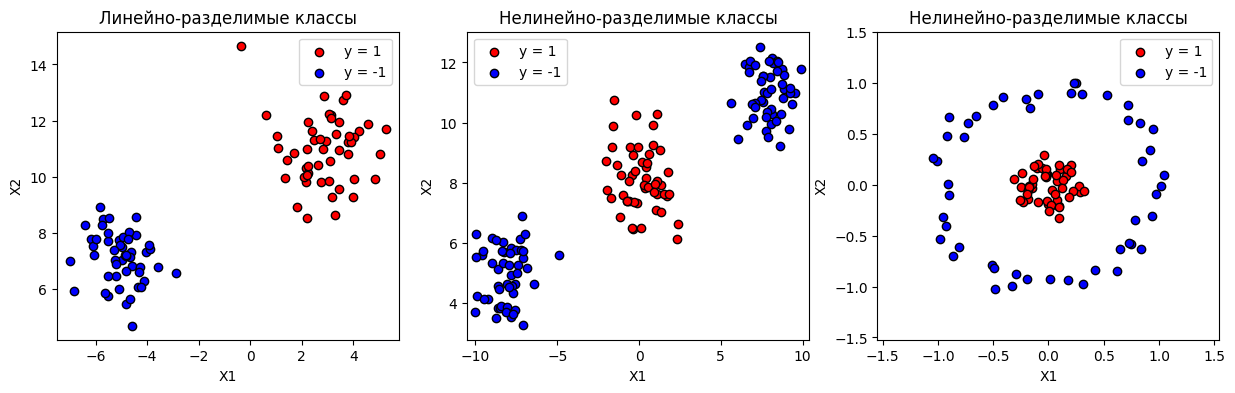

In [512]:
#Вывод графиков всех трех выборок
dataset = [X1, X2, X3]
answers = [y1, y2, y3]
description = ['Линейно-разделимые классы', 'Нелинейно-разделимые классы', 'Нелинейно-разделимые классы']

fig, ax = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    X = dataset[i]
    y = answers[i]
    title = description[i]
    graph(ax[i], X, y, title)
    

# 2.3 Протестируем линейный SVM на сгенерированных выборках. 

## Применим модель линйеного SVM на первой выборке и рассмотрим как меняется график, при изменении C:

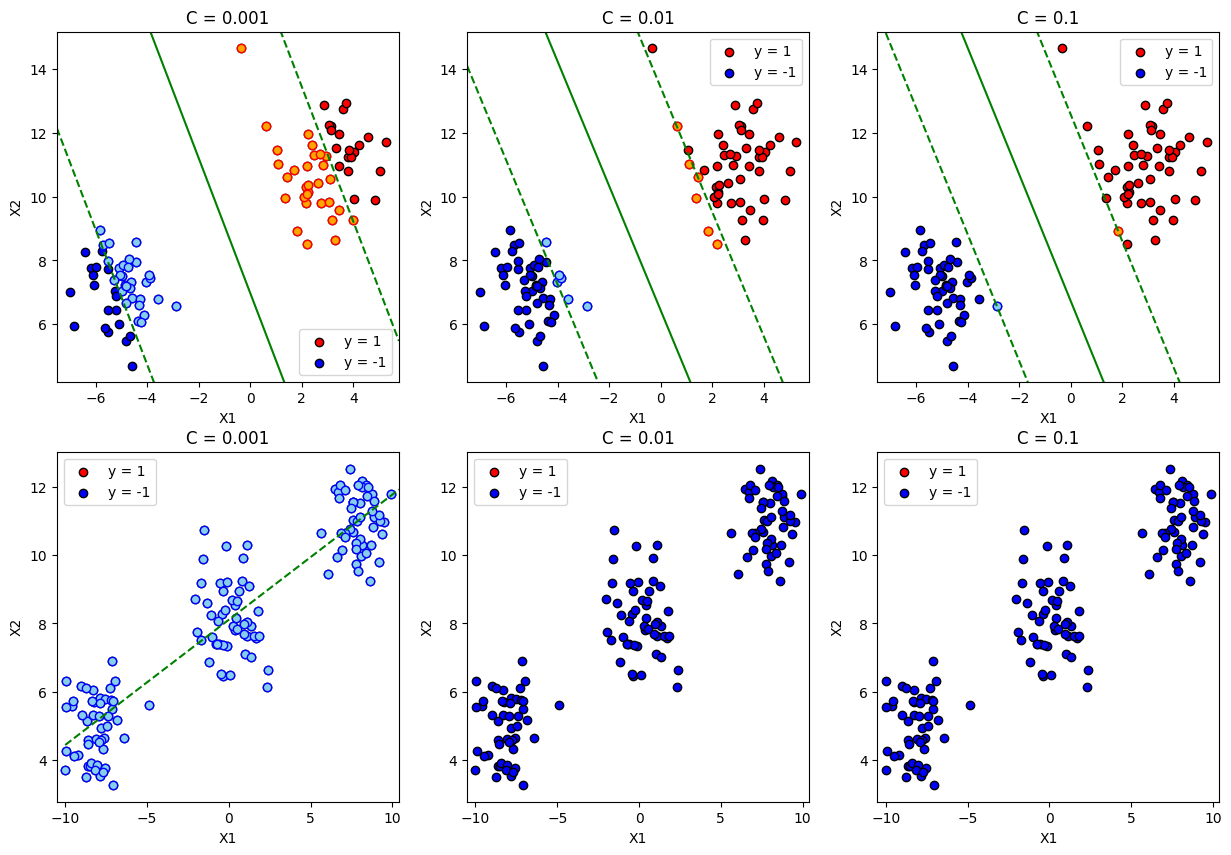

In [513]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
x_arr = np.linspace(-10, 15, 3000)

for i in range(2):
    X = dataset[i]
    y = answers[i]
    C = 0.0001
    for j in range(3):
        C = C * 10
        title = (f'C = {C}')
        eps = 0.01
        
        svm = LinearSVM(C)
        svm.fit(X, y)
        y = svm.predict(X)
        w, b = svm.coeff()
        a = svm.predict_proba(X)
        
        index = ((y * a - 1) - eps <= 0) * ((y * a + 1) - eps >= 0)
        vectors1 = X[(y == 1) * index]
        vectors2 = X[(y == -1) * index]
        
        graph(ax[i][j], X, y, title)
        ax[i][j].scatter(vectors1[:, 0], vectors1[:, 1], c='orange', edgecolor='red')
        ax[i][j].scatter(vectors2[:, 0], vectors2[:, 1], c='skyblue', edgecolor='blue')
        ax[i][j].plot(x_arr, -(b + w[0] * x_arr) / w[1], color = 'green')
        ax[i][j].plot(x_arr, (1 - b - w[0] * x_arr) / w[1], color = 'green', linestyle='dashed')
        ax[i][j].plot(x_arr, (-1 - b - w[0] * x_arr) / w[1], color = 'green', linestyle='dashed')

## Как видим, при увеличении С, коридор между опорными векторами сужается. А на нелинейно-разделимой выборке линейный SVM неправильно определяет классы.

## Применим линейный SVM на третьей выборке:

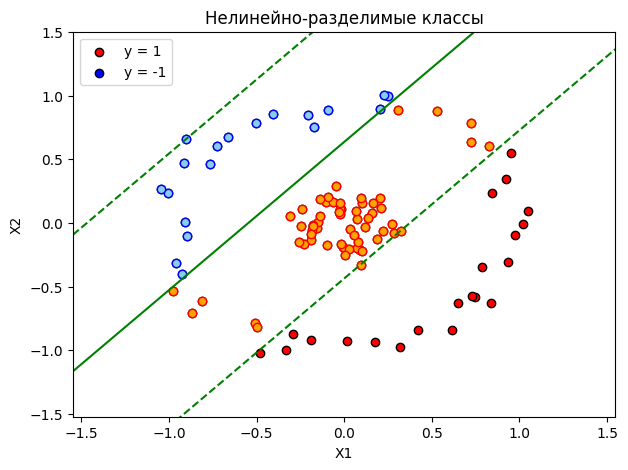

In [514]:
X = dataset[2]
y = answers[2]
C = 100
eps = 0.01
x_arr = np.linspace(-2, 2, 3000)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

svm = LinearSVM(C)
svm.fit(X, y)
y = svm.predict(X)
w, b = svm.coeff()
a = svm.predict_proba(X)

index = ((y * a - 1) - eps <= 0) * ((y * a + 1) - eps >= 0)
vectors1 = X[(y == 1) * index]
vectors2 = X[(y == -1) * index]

graph(ax, X, y, title='Нелинейно-разделимые классы')
ax.scatter(vectors1[:, 0], vectors1[:, 1], c='orange', edgecolor='red')
ax.scatter(vectors2[:, 0], vectors2[:, 1], c='skyblue', edgecolor='blue')
ax.plot(x_arr, -(b + w[0] * x_arr) / w[1], color = 'green')
ax.plot(x_arr, (1 - b - w[0] * x_arr) / w[1], color = 'green', linestyle='dashed')
ax.plot(x_arr, (-1 - b - w[0] * x_arr) / w[1], color = 'green', linestyle='dashed')

## Нелинейно-разделимые выборки классифицировать с помощью линейной SVM просто так не получается. 

# 2.4 Как можно заметить, число опорных векторов при увеличении параметра С уменьшается.

# 2.5 Используя явное преобразование признаков обучим методом опорных векторов квадратичную разделяющую поверхность. Покажим ее на плоскости.

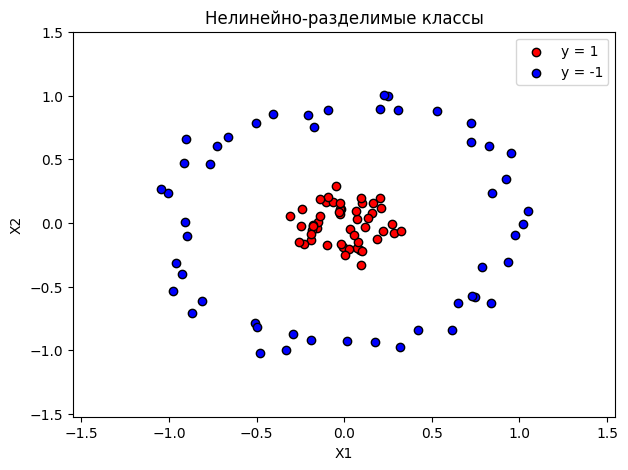

In [515]:
X = dataset[2]
y = answers[2]

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
graph(ax, X, y, title='Нелинейно-разделимые классы')

In [516]:
X_transform = square_transform(X)

x1 = X_transform[:, 0].reshape((-1, 1))
x2 = X_transform[:, 1].reshape((-1, 1))
x3 = (x1**2 + x2**2) # Добавляем новую координату вектора

X = np.hstack((x1, x3))

Text(0, 0.5, 'x1^2 + x2^2')

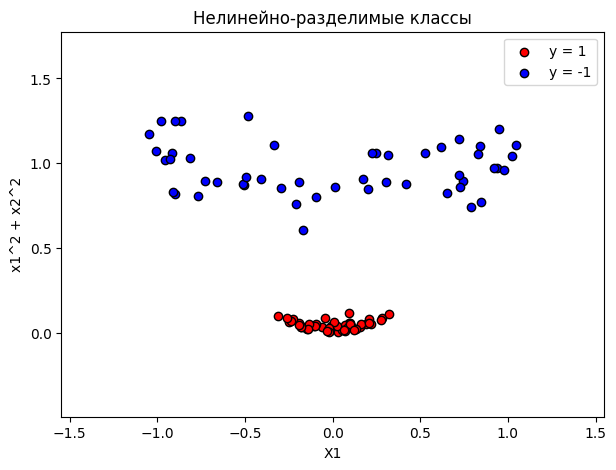

In [517]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
graph(ax, X, y, title='Нелинейно-разделимые классы')
plt.ylabel("x1^2 + x2^2")

Text(0, 0.5, 'x1^2 + x2^2')

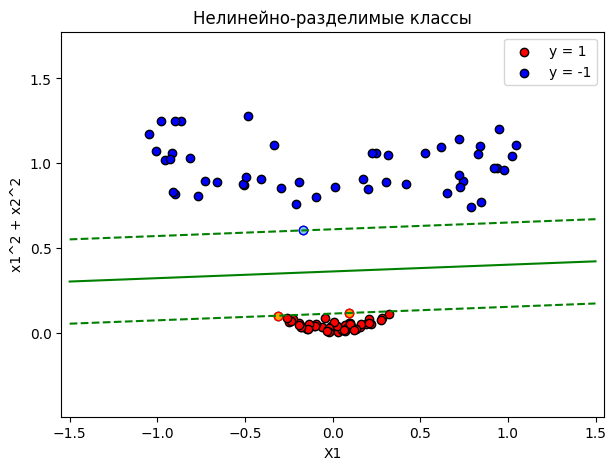

In [518]:
C = pow(10, 2)
eps = 0.01

svm.fit(X, y)
y = svm.predict(X)
w, b = svm.coeff()
a = svm.predict_proba(X)
x_arr = np.linspace(-1.5, 1.5, 3000)

index = ((y * a - 1) - eps <= 0) * ((y * a + 1) - eps >= 0)
x_vectors0 = X[(y == 1) * index]
x_vectors1 = X[(y == -1) * index]

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
graph(ax, X, y, title='Нелинейно-разделимые классы')

ax.scatter(x_vectors0[:, 0], x_vectors0[:, 1], c='orange', edgecolor='red')
ax.scatter(x_vectors1[:, 0], x_vectors1[:, 1], c='skyblue', edgecolor='blue')

ax.plot(x_arr, -(b + w[0] * x_arr) / w[1], color = 'green')
ax.plot(x_arr, (1 - b - w[0] * x_arr) / w[1], color = 'green', linestyle='dashed')
ax.plot(x_arr, (-1 - b - w[0] * x_arr) / w[1], color = 'green', linestyle='dashed')
plt.ylabel("x1^2 + x2^2")

C:\Users\switc\AppData\Local\Temp\ipykernel_9076\445372697.py:35: UserWarning: The following kwargs were not used by contour: 'linestyle'
  contour(xx1, xx2, zz, levels=(-1,), colors='k', linewidths=1.5, linestyle='dashed', zorder=3)


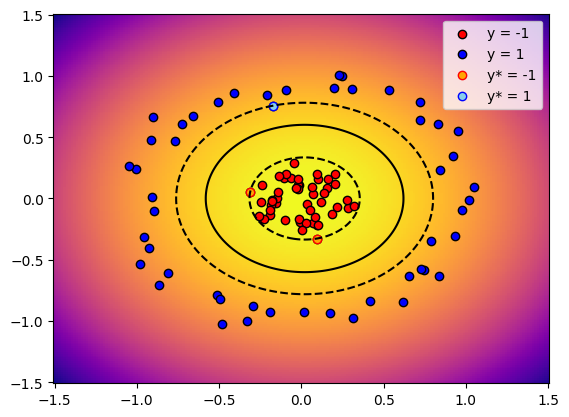

In [519]:
X = np.hstack((x1, x2))
new_X = np.hstack((x1, x3))

x1vals = linspace(-1.5, 1.5, 200)
x2vals = linspace(-1.5, 1.5, 200)

xx1, xx2 = np.meshgrid(x1vals, x2vals)
xx3 = xx1 ** 2 + xx2 ** 2

zz = np.reshape(svm.predict_proba(c_[xx1.ravel(), xx3.ravel()]), xx2.shape)

X_class1 = X[y == 1]
X_class2 = X[y == -1]

a = svm.predict_proba(new_X)
eps = 0.05

index = ((y * a - 1) - eps <= 0) * ((y * a + 1) - eps >= 0)
x_vectors0 = X[(y==1) * index]
x_vectors1 = X[(y==-1) * index]

scatter(X_class1[:, 0], X_class1[:, 1], color='red', edgecolor='k')
scatter(X_class2[:, 0], X_class2[:, 1], color='blue', edgecolor='k')

plt.scatter(x_vectors0[:, 0], x_vectors0[:, 1], c='orange', edgecolor='red')
plt.scatter(x_vectors1[:, 0], x_vectors1[:, 1], c='skyblue', edgecolor='blue')
plt.legend(['y = -1', 'y = 1', 'y* = -1', 'y* = 1'])

# Цветной фон, соответствующий значению решающего правила
pcolormesh(xx1, xx2, zz, cmap='plasma', zorder=0)

# Линия уровня, соответствующая значению 0.5
contour(xx1, xx2, zz, levels=(0,), colors='k', linewidths=1.5)
contour(xx1, xx2, zz, levels=(1,), colors='k', linewidths=1.5, linestyles='dashed', zorder=2)
contour(xx1, xx2, zz, levels=(-1,), colors='k', linewidths=1.5, linestyle='dashed', zorder=3)

# 3. Двойственный переход и Ядровой SVM

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования, решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](./SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит вектора признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в вектора очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_. 

#### Задание
  1. Реализуйте процедуру обучения ядрового SVM, используя QP-солвер.
  2. Протестируйте на случайных двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
    - линейная: $k(x, x') = x^Tx'$
    - полиномиальная: $k(x, x') = (x^Tx' + 1)^p$ с различными степенями $p = 2,3,\dots$
    - Гауссовская-RBF: $k(x, x') = \exp(-\frac{1}{2\gamma}\|x - x'\|^2)$
  3. Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $p$?
  4. Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\gamma$? Поварьируйте параметры $C$ и $\gamma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

# 3.1 Реализуем процедуру обучения ядрового SVM, используя QP-солвер.

In [568]:
class DualSVM(BaseEstimator):

    def __init__(self, C, X, y, kernel, p, gamma):
        self.C = C
        self.X = X
        self.y = y.reshape(1, -1)
        self.kernel_method = kernel
        self.M, self.n = np.shape(X)
        self.p = p
        self.gamma = gamma
        
    def kernel(self, X1, X2):
        if self.kernel_method == 'linear':
            return np.dot(X1, X2.T)
        
        elif self.kernel_method == 'poly':
            return pow((np.dot(X1, X2.T) + 1), self.p)
        
        elif self.kernel_method == 'rbf':
            v1 = np.linalg.norm(X1.T, axis=0) ** 2 
            v2 = np.linalg.norm(X2.T, axis=0) ** 2
            
            x = ((-2 * np.dot(X1, X2.T) + v2).T + v1).T / -(2 * self.gamma)
            return np.exp(x)
        
    def compute_cvx_matrices(self, X, y):
        M = self.M
        P = matrix(self.kernel(X * y.T, X * y.T))
        q = matrix(-np.ones((M)))
        G = matrix(np.vstack((-(np.eye(M)), (np.eye(M)))))
        h = matrix(np.hstack((np.zeros(M), np.repeat(self.C, M))))
        A = matrix(y)
        b = matrix(0.0)
        
        return P, q, G, h, A, b
        
    def fit(self):
        X = self.X
        y = self.y
        
        P, q, G, h, A, b = self.compute_cvx_matrices(X, y)
        sol = solvers.qp(P, q, G, h, A, b)
        solvers.options['show_progress'] = False
        
        self.alpha = np.array(sol["x"])
        self.S = (self.alpha > 10 ** -6).flatten()
        S = self.S
        self.support_vectors = X[S]
        kernel = self.kernel(self.support_vectors, self.support_vectors)
        self.bias = np.mean(y.T[S] - np.dot(kernel, (self.alpha[S] * y.T[S])))

    def predict_proba(self, X):
        y = self.y
        S = self.S
        kernel = self.kernel(self.support_vectors, X)
        return (np.dot((self.alpha[S] * y.T[S]).T, kernel) + self.bias).flatten()
            
    def predict(self, X):
        return sign(self.predict_proba(X))
    
    def vectors(self):
        return self.S

# 3.2 Протестируем на случайных двумерных выборках ядровой SVM. Попробуем разные ядровые функции.

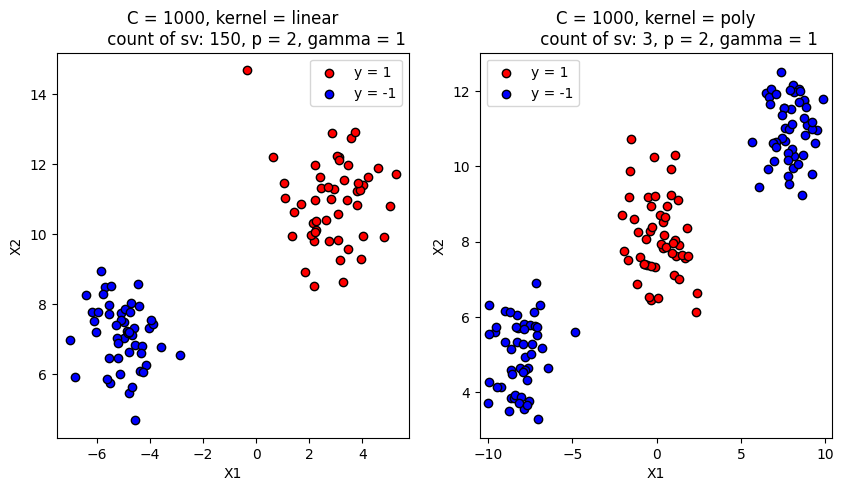

In [569]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i in range(2):
    X = dataset[i]
    y = answers[i]
    graph(ax[i], X, y, description[i])

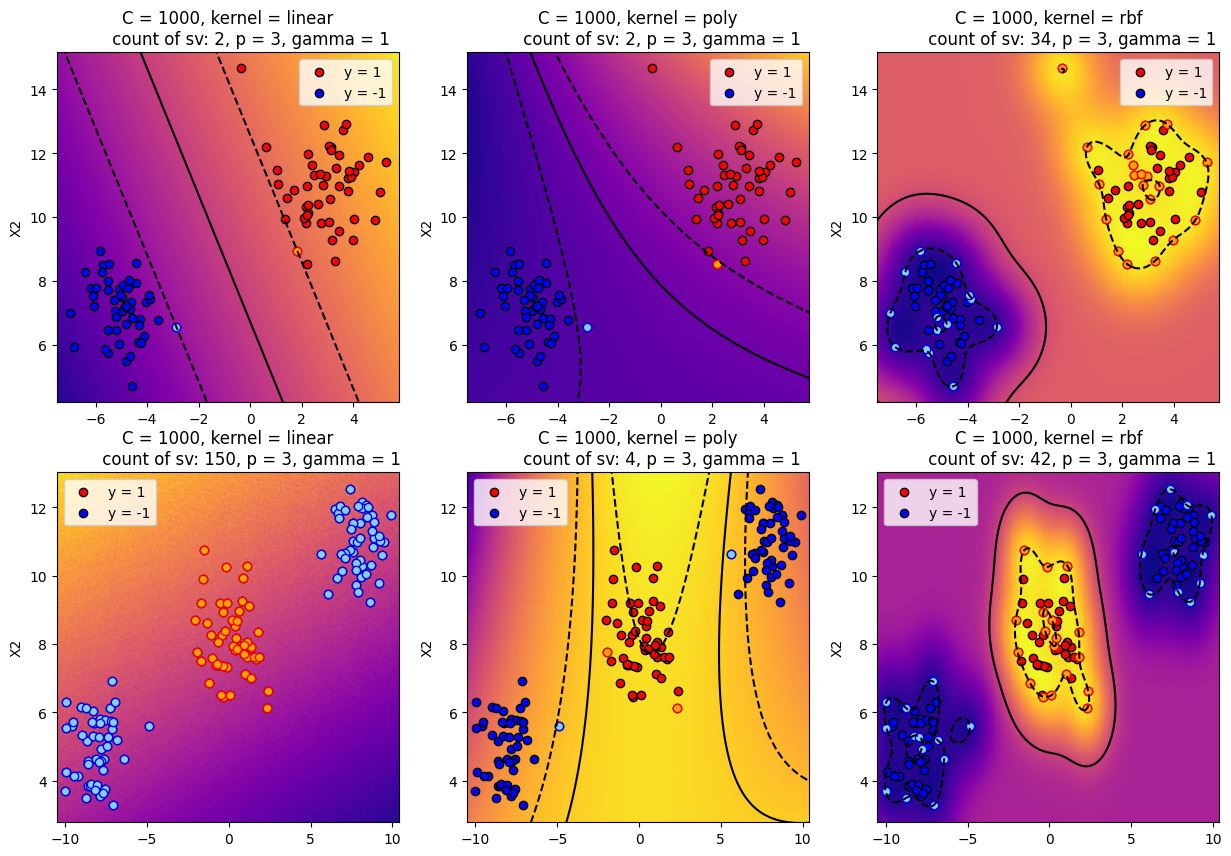

In [570]:
kernel = ['linear', 'poly', 'rbf']

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
C = 1000
p = 3
gamma = 1

for i in range(2):
    for j in range(3):
        X = dataset[i]
        y = answers[i]
        y = y.astype(float64)
        
        svm = DualSVM(C, X, y, kernel[j], p, gamma)
        svm.fit()
        
        xvals = np.linspace(min(X[:, 0]) - 1, max(X[:, 0]) + 1, 200)
        yvals = np.linspace(min(X[:, 1]) - 1, max(X[:, 1]) + 1, 200)
        
        xx, yy = np.meshgrid(xvals, yvals)
    
        XX = np.array([xx.ravel(), yy.ravel()])
        zz = np.reshape(svm.predict_proba(XX.T), yy.shape)
        
        S = svm.vectors()
        vectors1 = X[(y == 1) * S]
        vectors2 = X[(y == -1) * S]
        
        description[j] = (f'C = {C}, kernel = {kernel[j]}\n \
        count of sv: {sum(S)}, p = {p}, gamma = {gamma}')
        c = ax[i][j].pcolormesh(xx, yy, zz, cmap='plasma', zorder=0)
    
        ax[i][j].contour(xx, yy, zz, levels=(1.0,), colors='k', linewidths=1.5, linestyles ='dashed')
        ax[i][j].contour(xx, yy, zz, levels=(0.0,), colors='k', linewidths=1.5)
        ax[i][j].contour(xx, yy, zz, levels=(-1.0,), colors='k', linewidths=1.5, linestyles ='dashed')
        graph(ax[i][j], X, y, description[j])
        ax[i][j].scatter(vectors1[:, 0], vectors1[:, 1], c='orange', edgecolor='red')
        ax[i][j].scatter(vectors2[:, 0], vectors2[:, 1], c='skyblue', edgecolor='blue')
        ax[i][j].set_xlabel("")

## 3.3 Посмотрим, как ведет себя SVM с полиномиальным ядром в зависимости от параметров  𝐶 и степени ядра  𝑝.


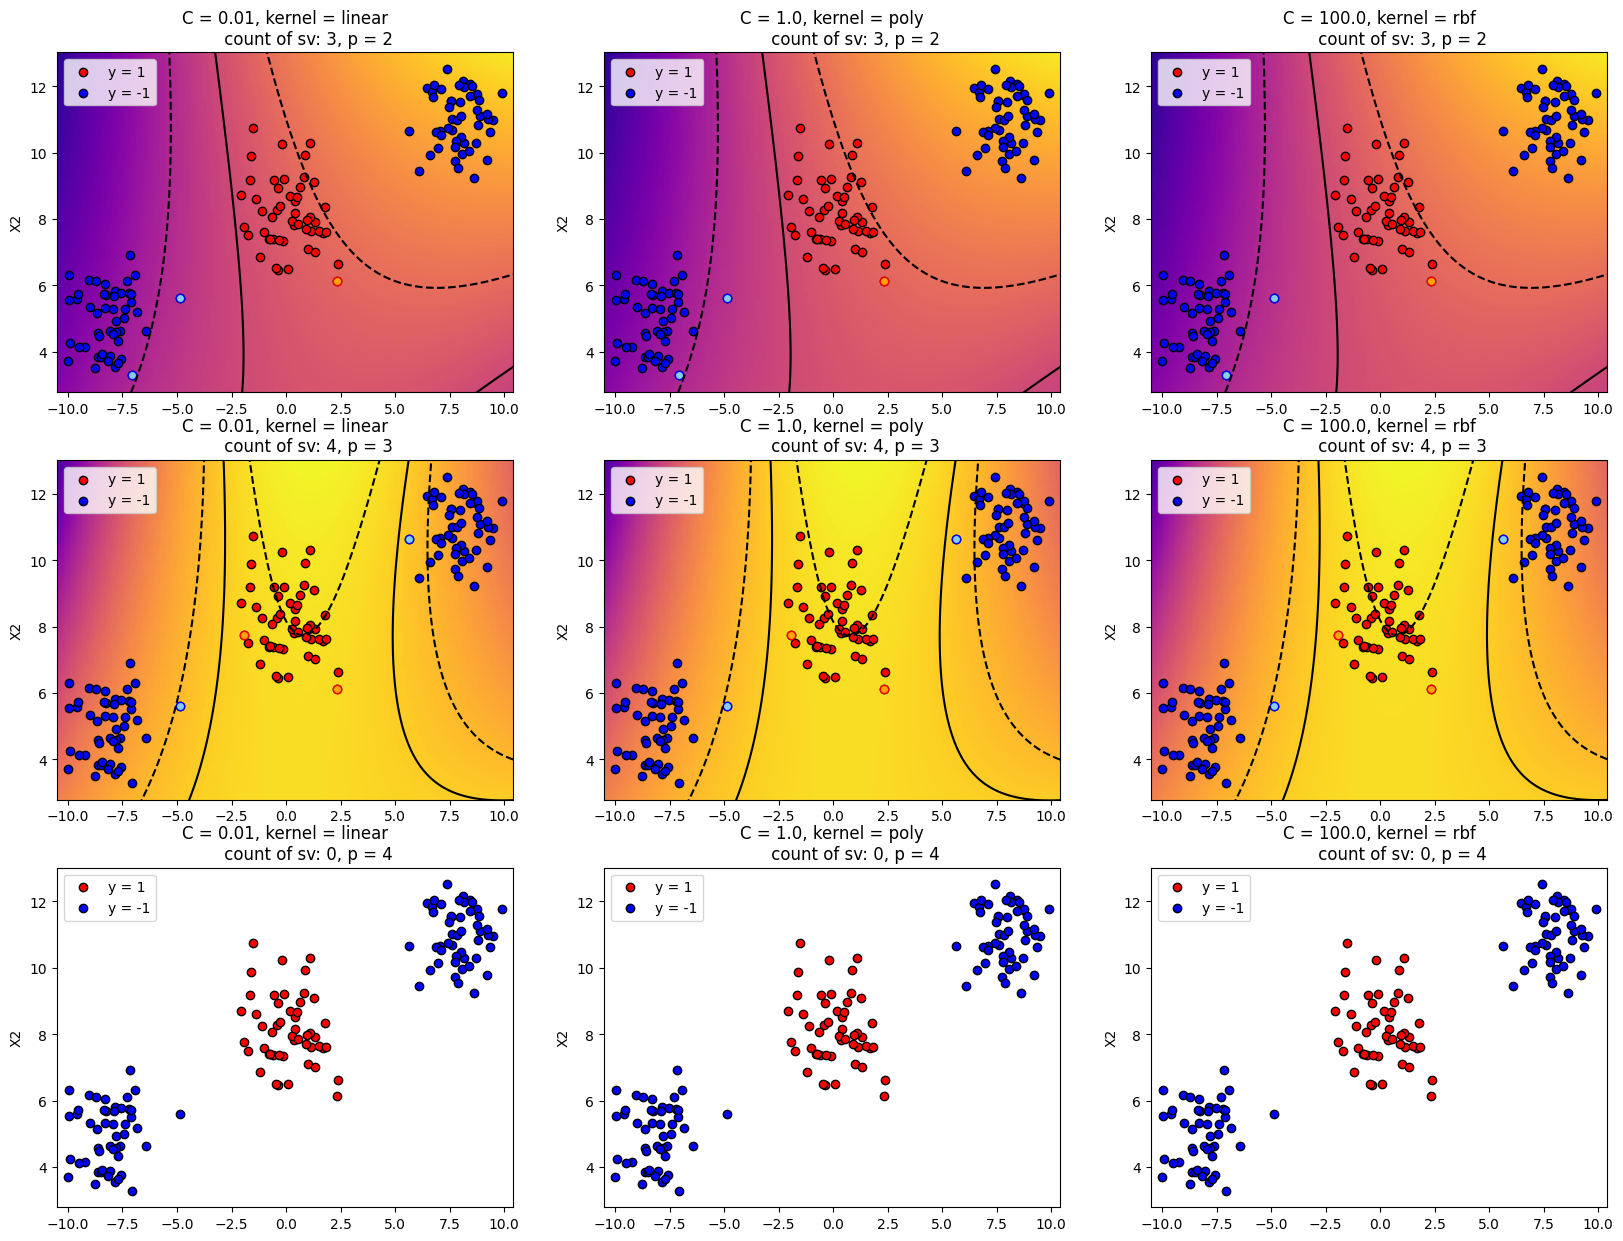

In [592]:
kernel = ['linear', 'poly', 'rbf']

fig, ax = plt.subplots(3, 3, figsize=(20, 15))
parametr = 0.0001
p = 1
gamma = 1
X = dataset[1]
y = answers[1]
y = y.astype(float64)


for i in range(3):
    p = p + 1
    C = parametr
    for j in range(3):
        C = C * 100
        svm = DualSVM(C, X, y,'poly', p, gamma)
        svm.fit()
        
        xvals = np.linspace(min(X[:, 0]) - 1, max(X[:, 0]) + 1, 200)
        yvals = np.linspace(min(X[:, 1]) - 1, max(X[:, 1]) + 1, 200)
        
        xx, yy = np.meshgrid(xvals, yvals)
    
        XX = np.array([xx.ravel(), yy.ravel()])
        zz = np.reshape(svm.predict_proba(XX.T), yy.shape)
        
        S = svm.vectors()
        vectors1 = X[(y == 1) * S]
        vectors2 = X[(y == -1) * S]
        
        description[j] = (f'C = {C}, kernel = {kernel[j]}\n \
        count of sv: {sum(S)}, p = {p}')
        c = ax[i][j].pcolormesh(xx, yy, zz, cmap='plasma', zorder=0)
    
        ax[i][j].contour(xx, yy, zz, levels=(1.0,), colors='k', linewidths=1.5, linestyles ='dashed')
        ax[i][j].contour(xx, yy, zz, levels=(0.0,), colors='k', linewidths=1.5)
        ax[i][j].contour(xx, yy, zz, levels=(-1.0,), colors='k', linewidths=1.5, linestyles ='dashed')
        graph(ax[i][j], X, y, description[j])
        ax[i][j].scatter(vectors1[:, 0], vectors1[:, 1], c='orange', edgecolor='red')
        ax[i][j].scatter(vectors2[:, 0], vectors2[:, 1], c='skyblue', edgecolor='blue')
        ax[i][j].set_xlabel("")

## 3.4 Посмотрим, как ведет себя SVM с RBF-ядром в зависимости от параметров  𝐶 и  𝛾.

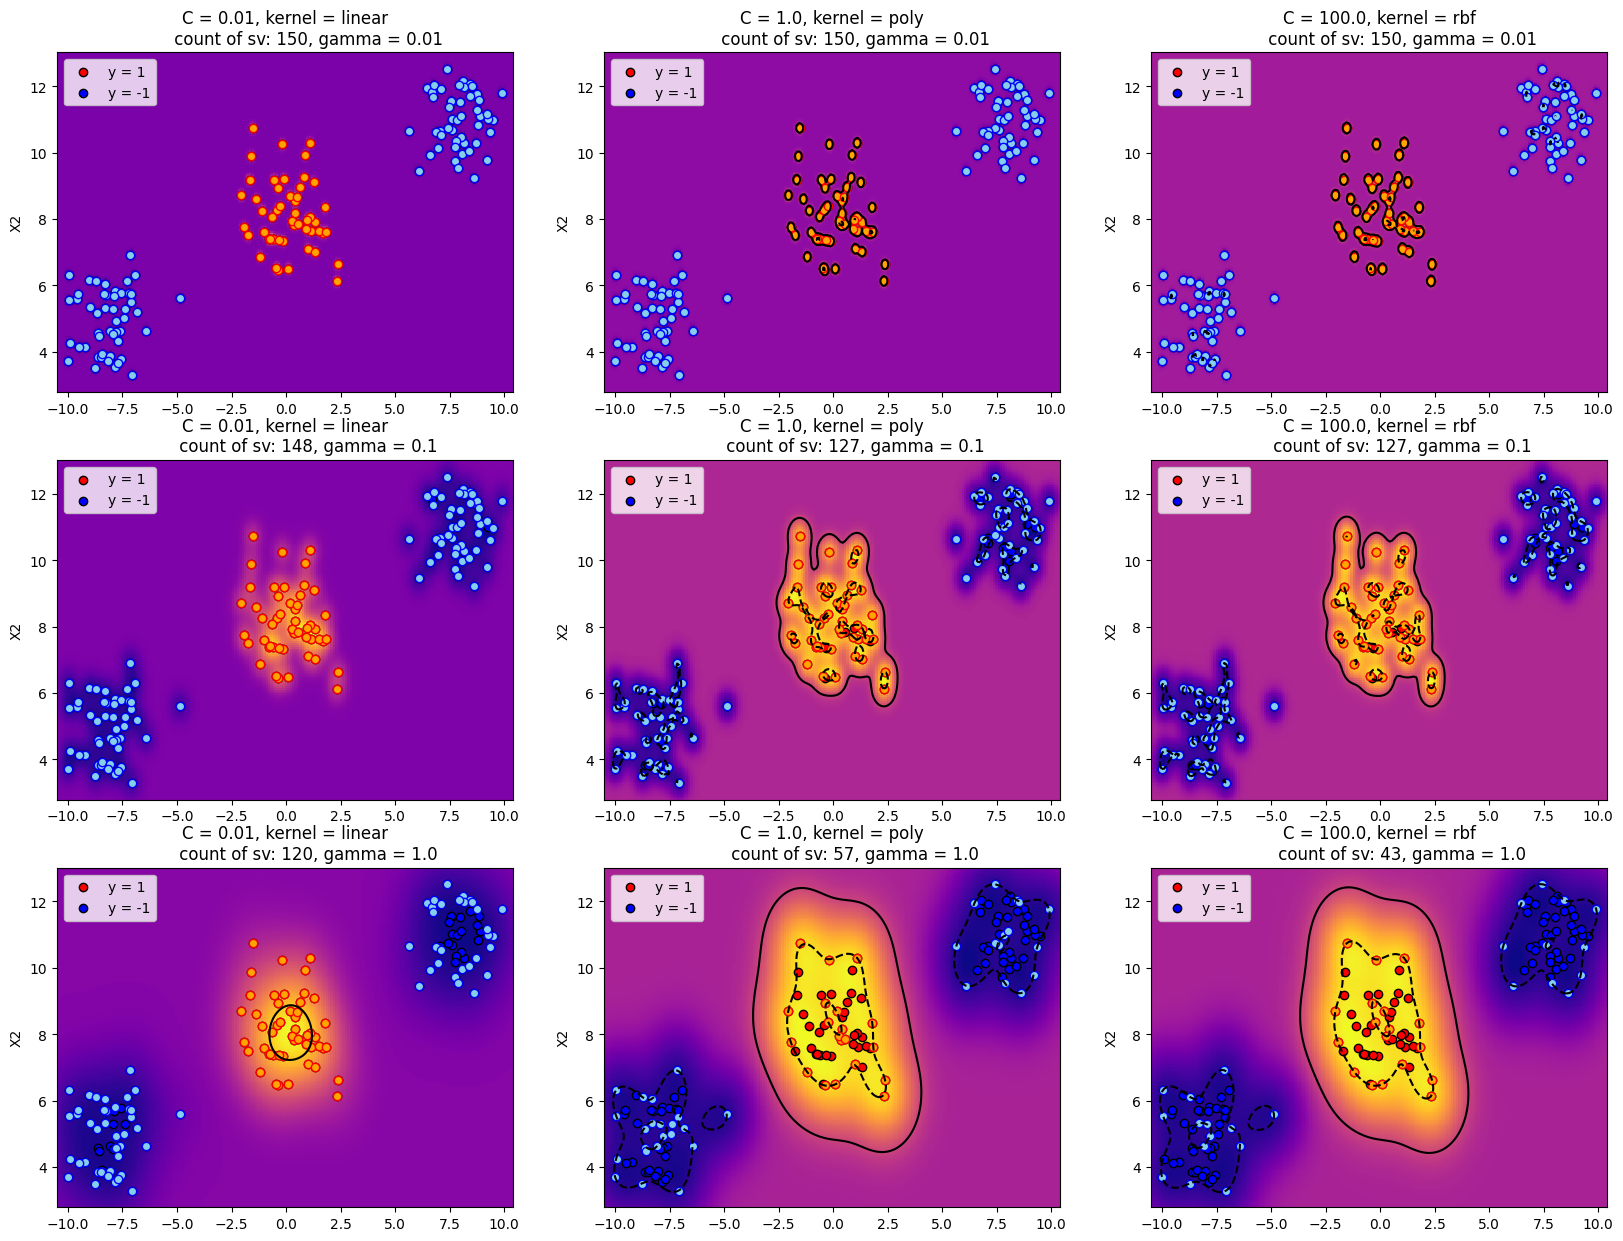

In [588]:
kernel = ['linear', 'poly', 'rbf']

fig, ax = plt.subplots(3, 3, figsize=(20, 15))
parametr = 0.0001
p = 2
gamma = 0.001
X = dataset[1]
y = answers[1]
y = y.astype(float64)


for i in range(3):
    gamma = gamma * 10
    C = parametr
    for j in range(3):
        C = C * 100
        svm = DualSVM(C, X, y,'rbf', p, gamma)
        svm.fit()
        
        xvals = np.linspace(min(X[:, 0]) - 1, max(X[:, 0]) + 1, 200)
        yvals = np.linspace(min(X[:, 1]) - 1, max(X[:, 1]) + 1, 200)
        
        xx, yy = np.meshgrid(xvals, yvals)
    
        XX = np.array([xx.ravel(), yy.ravel()])
        zz = np.reshape(svm.predict_proba(XX.T), yy.shape)
        
        S = svm.vectors()
        vectors1 = X[(y == 1) * S]
        vectors2 = X[(y == -1) * S]
        
        description[j] = (f'C = {C}, kernel = {kernel[j]}\n \
        count of sv: {sum(S)}, gamma = {gamma}')
        c = ax[i][j].pcolormesh(xx, yy, zz, cmap='plasma', zorder=0)
    
        ax[i][j].contour(xx, yy, zz, levels=(1.0,), colors='k', linewidths=1.5, linestyles ='dashed')
        ax[i][j].contour(xx, yy, zz, levels=(0.0,), colors='k', linewidths=1.5)
        ax[i][j].contour(xx, yy, zz, levels=(-1.0,), colors='k', linewidths=1.5, linestyles ='dashed')
        graph(ax[i][j], X, y, description[j])
        ax[i][j].scatter(vectors1[:, 0], vectors1[:, 1], c='orange', edgecolor='red')
        ax[i][j].scatter(vectors2[:, 0], vectors2[:, 1], c='skyblue', edgecolor='blue')
        ax[i][j].set_xlabel("")